## Notebook for making and plotting predictions
To use: change the parameters in the first code cell appropriately. Run all following cells to plot the predictions of a given model checkpoint, as well as to calculate the RMSE and r-coefficient. 

In [14]:
experiment_path = 'checkpoints/experiments_finetune_5epochs_ed_frozen_20241210_222748'
checkpoint_name = 'epoch=4-train_loss=0.28.ckpt'

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import os
from os import path as osp
import torch
import torch_geometric
from torch_geometric.data import Batch
from tqdm import tqdm
import matplotlib.cm as cm
import scienceplots
from scipy.stats import pearsonr
import xarray as xr

from models.master_model import MasterModel
from config import *
from utils.data_utils import GODAS
from torch_geometric.data import Batch

In [11]:
dataset = GODAS(adjacency_method='multimesh1')
num_graphs = len(dataset)
# loading label timeseries
labels = xr.open_dataset(f'data/GODAS/raw/GODAS_regridded.nc', engine="netcdf4")['oni'].to_numpy() 
dates = pd.Series(xr.open_dataset(f'data/GODAS/raw/GODAS_regridded.nc', engine="netcdf4")['time'].to_numpy()).dt.strftime('%Y-%m').to_numpy()
dates = dates[36:-1]
# currently month 1 as first elem - we want month 37
labels = labels[36:-1]

In [15]:
if not os.path.exists(osp.join(experiment_path, f'{checkpoint_name}_GODAS_predictions.pt')):
    device = torch.device('cuda' if torch.cuda.is_available() and torch.cuda.current_device() != 0 else 'cpu')
    print(f'Using {device}')

    predictor = MasterModel.load_from_checkpoint(osp.join(experiment_path, checkpoint_name), map_location=device)

    predictor.to(device)  
    predictor.eval()

    graphs = [0] + [dataset.get(i).to(device) for i in range(35)]
    predictions = []

    for i in tqdm(range(num_graphs - 36 + 1)): 
        graphs = graphs[1:]
        graphs.append(dataset.get(i+35).to(device))
        batch = Batch.from_data_list(graphs).to(device)
        with torch.no_grad():
            predictions.append(predictor(batch))

    predictions = torch.stack(predictions, dim=0)
    torch.save(predictions, osp.join(experiment_path, f'{checkpoint_name}_GODAS_predictions.pt'))

predictions = torch.load(osp.join(experiment_path, f'{checkpoint_name}_GODAS_predictions.pt'))
predictions = predictions.reshape(predictions.size(0), -1)

Using cpu


100%|██████████| 478/478 [18:11<00:00,  2.28s/it]
/tmp/ipykernel_90772/4092921519.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictions = torch.load(osp.join(expe

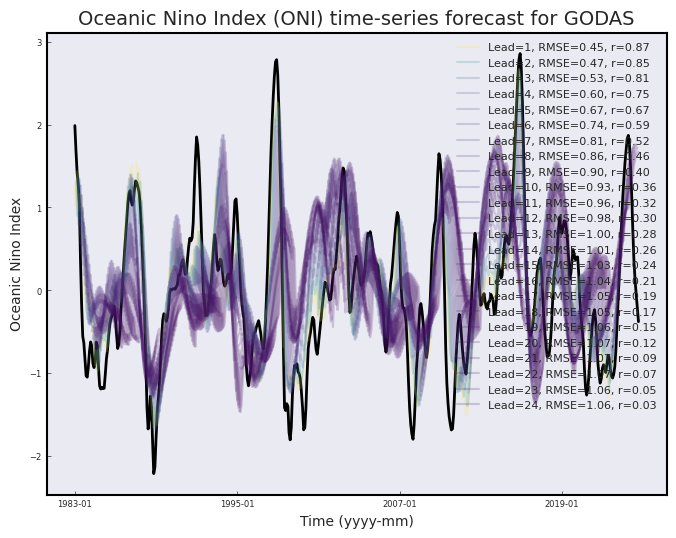

In [16]:
plt.style.use('seaborn-v0_8-dark')
plt.figure(figsize=(8, 6)) 
cmap = cm.viridis
plt.plot(dates, labels, linewidth=2, color='black')

for lead in range(24):
    lead_prediction = predictions[:, lead].numpy()
    gt = labels[lead:lead+len(lead_prediction)]
    dates_adjusted = dates[lead:lead+len(lead_prediction)]
    rmse = np.sqrt(np.mean((gt - lead_prediction) ** 2))
    r, _ = pearsonr(gt, lead_prediction)
    plt.plot(dates_adjusted, lead_prediction, color=cmap(1/(lead+1)), label=f'Lead={lead+1}, RMSE={f"{rmse:.2f}"}, r={f"{r:.2f}"}', alpha=0.2)

plt.title(f'Oceanic Nino Index (ONI) time-series forecast for GODAS', fontsize=14)
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Time (yyyy-mm)', fontsize=10)
plt.ylabel('Oceanic Nino Index', fontsize=10)
plt.tick_params(labelsize=6,direction='in',length=3,width=0.4,color='black')
current_ticks = plt.gca().get_xticks()
new_ticks = current_ticks[::144]
plt.xticks(new_ticks, fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the spine color
    spine.set_linewidth(1.5)  # Set the spine width
plt.show()

/tmp/ipykernel_52141/1699659030.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  p = torch.load(file)


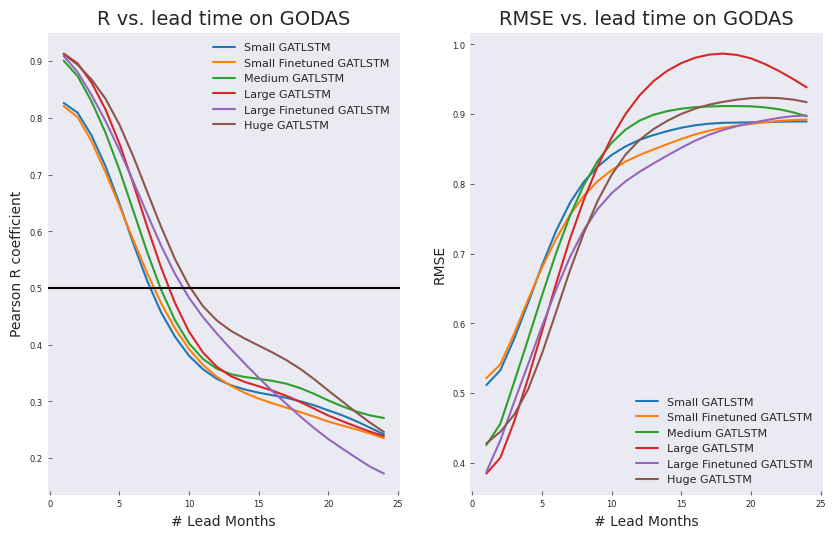

In [10]:
plt.style.use('seaborn-v0_8-dark')
cmap = cm.viridis

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

prediction_files = ['checkpoints/GATLSTM_newdata_small_20241209_124456/epoch=4-train_loss=0.67.ckpt_GODAS_predictions.pt',
    'checkpoints/GATLSTM_newdata_small_20241209_124456_finetune/epoch=4-train_loss=0.56.ckpt_GODAS_predictions.pt',
    'checkpoints/GATLSTM_newdata_medium_20241209_154802/epoch=9-train_loss=0.59.ckpt_GODAS_predictions.pt',
    'checkpoints/GATLSTM_newdata_large_20241209_161418/epoch=5-train_loss=0.58.ckpt_GODAS_predictions.pt',
    'checkpoints/GATLSTM_newdata_large_20241209_161418_finetune_10epochs_1e-5_20241209_233639/epoch=0-train_loss=0.53.ckpt_GODAS_predictions.pt',
    'checkpoints/experiments/huge_gatlstm_epoch=3-train_loss=0.54.ckpt_GODAS_predictions.pt'
    ]

model_labels = ['Small GATLSTM',
    'Small Finetuned GATLSTM',
    'Medium GATLSTM',
    'Large GATLSTM',
    'Large Finetuned GATLSTM',
    'Huge GATLSTM'
    ]

rs = []
rmses = []
for file in prediction_files:
    p = torch.load(file)
    p = p.reshape(p.size(0), -1)
    temp_rs = []
    temp_rmses = []
    for lead in range(24):
        lead_prediction = p[:, lead].numpy()
        gt = labels[lead:lead+len(lead_prediction)]
        rmse = np.sqrt(np.mean((gt - lead_prediction) ** 2))
        temp_rmses.append(rmse)
        r, _ = pearsonr(gt, lead_prediction)
        temp_rs.append(r)
    rs.append(temp_rs)
    rmses.append(temp_rmses)

for i, (model_rs, model_rmses) in enumerate(zip(rs, rmses)):
    axs.flat[0].plot(np.arange(1, 25), model_rs, label=model_labels[i])
    axs.flat[1].plot(np.arange(1, 25), model_rmses, label=model_labels[i])

for ax in axs.flat:
    ax.set_xlabel('# Lead Months', fontsize=10)
    ax.tick_params(labelsize=6,direction='in',length=3,width=0.4,color='black')

axs.flat[0].set_title(f'R vs. lead time on GODAS', fontsize=14)
axs.flat[1].set_title(f'RMSE vs. lead time on GODAS', fontsize=14)
axs.flat[0].set_ylabel('Pearson R coefficient', fontsize=10)
axs.flat[1].set_ylabel('RMSE', fontsize=10)
axs.flat[0].legend(loc='upper right', fontsize=8)
axs.flat[1].legend(loc='lower right', fontsize=8)
axs.flat[0].axhline(y=0.5, color='black')

plt.show()

In [37]:
print(rs[3])

[np.float64(0.8671542107878736), np.float64(0.8260385544348594), np.float64(0.7765540317455475), np.float64(0.7246125886851473), np.float64(0.6668561934738193), np.float64(0.6014924079772683), np.float64(0.5313957615077953), np.float64(0.4592222256810601), np.float64(0.3920313103164972), np.float64(0.3340135650665843), np.float64(0.28826476244141475), np.float64(0.25195898574816056), np.float64(0.22316845049681433), np.float64(0.19992623677033805), np.float64(0.1818632412569059), np.float64(0.16682370388991785), np.float64(0.15348038848702572), np.float64(0.1405925583477199), np.float64(0.1275192978779387), np.float64(0.11358340778474485), np.float64(0.09814441430353327), np.float64(0.08247406448094807), np.float64(0.06769055270012814), np.float64(0.054770143373545466)]
